# Walmart M5 Forecasting Solution - Approach 1 & Results

## 1. Objective
We aim to forecast daily sales for Walmart stores across multiple categories and locations over two 28-day periods:
- **Validation**: `d_1914–d_1941`
- **Evaluation**: `d_1942–d_1969`

The final output is a submission file combining both predictions in the required M5 competition format.

---

## 2. Data Processing & Memory Optimization
- Joined sales, pricing and calendar data
- Filtered data for Year >= 2013 to reduce memory usage
- Applied a custom `reduce_mem_usage()` function to minimize RAM usage via downcasting.

---

## 3. Feature Engineering
We engineered several meaningful features to help the model learn temporal and pricing patterns:

### Lag Features
- `sales_lag_1`, `sales_lag_7`, `sales_lag_14`, `sales_lag_28`

### Rolling Mean & Std
- Windows: 7, 14, 28, 60, 180 days
- Features: `rolling_mean_*`, `rolling_std_*`

### Price Dynamics
- `price_max`, `price_min`, `price_std`
- `price_norm`, `price_momentum`

### Time-Based Features
- Day (`tm_d`), Day of Week (`tm_dw`), Weekend (`tm_w_end`), Week of Month (`tm_wm`), Month (`tm_m`), Year (`tm_y`)

---

## 4. Cross-Validation Strategy
Time-based validation folds were used to preserve temporal structure.

```text
Fold 1: Train d_1–d_1577 → Predict d_1578–d_1605  
Fold 2: Train d_1–d_1829 → Predict d_1830–d_1857  
Fold 3: Train d_1–d_1857 → Predict d_1858–d_1885  
Fold 4: Train d_1–d_1885 → Predict d_1886–d_1913  
Fold 5: Train d_1–d_1913 → Predict d_1914–d_1941 (Validation)  
```

Models were trained for each **store × 7-day week block** to localize patterns and increase granularity.

---

## 5. Modeling Approach
- Used **LightGBM** with **Tweedie regression** (`tweedie_variance_power = 1.1`) to handle zero-inflated demand.
- GPU-accelerated (`device: gpu`) for fast training.
- One model trained per:
  - **Store ID**
  - **7-day window** within the 28-day horizon
- **Final Holdout RMSE (d1914–1941): 0.0611**
---

## 6. Forecasting Strategy

### Validation (d_1914–1941)
- Used CV-trained models
- Calculated RMSE per fold and overall

### Evaluation (d_1942–1969)
- Extended base data with future rows using calendar + price

## 7. Kaggle Submission
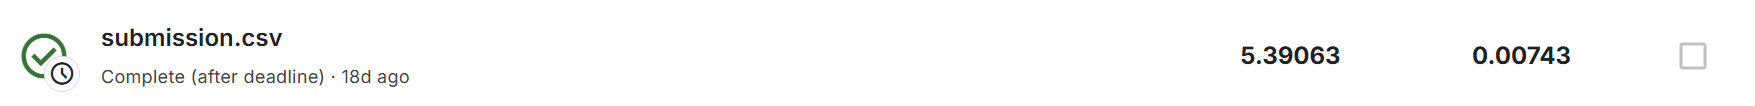

## Import Libraries

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import gc  # Garbage collection
import warnings
warnings.filterwarnings('ignore')  # To keep output clean

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

## Helper Function to Downcast


In [2]:
# Helper Function to Downcast
def reduce_mem_usage(df, verbose=True):
    """ 
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Memory usage reduced from {start_mem:.2f} MB to {end_mem:.2f} MB ({100*(start_mem-end_mem)/start_mem:.1f}% reduction)")
    return df

## Load Data

In [3]:
# Load the sales_long_recent CSV (normal way)

sales_long_recent = pd.read_csv('sales_recent.csv')  # ← Change path if needed

print("CSV loaded successfully!")

sales_long_recent = reduce_mem_usage(sales_long_recent)

gc.collect()

# Ensure 'd' column is numeric
if sales_long_recent['d'].dtype == object:
    sales_long_recent['d'] = sales_long_recent['d'].str.replace('d_', '').astype(int)

print("Data downcasted and memory cleaned successfully!")

CSV loaded successfully!
Memory usage reduced from 6335.64 MB to 4211.76 MB (33.5% reduction)
Data downcasted and memory cleaned successfully!


## Feature Engineering

### Lag features 

In [4]:
# lag features 

def create_lag_features(df, lags=[1, 7, 14, 28]):
    for lag in lags:
        df[f'sales_lag_{lag}'] = df.groupby('id')['sales'].shift(lag)
    print("Shape after transformation:", df.shape)
    return df

### Rolling features 

In [5]:
# Rolling features 
def create_rolling_features(df, windows=[7, 14, 28, 60, 180]):
    for window in windows:
        df[f'rolling_mean_{window}'] = (
            df.groupby('id')['sales'].shift(1).rolling(window).mean()
        )
        df[f'rolling_std_{window}'] = (
            df.groupby('id')['sales'].shift(1).rolling(window).std()
        )
    print("Shape after transformation:", df.shape)
    return df

### Calendar features

In [6]:
# Calendar features 
def create_calendar_features(df):
    df['tm_d'] = df['date'].dt.day
    df['tm_dw'] = df['date'].dt.weekday
    df['tm_w_end'] = (df['tm_dw'] >= 5).astype(np.int8)
    df['tm_wm'] = df['date'].dt.day // 7
    df['tm_m'] = df['date'].dt.month
    df['tm_y'] = df['date'].dt.year
    print("Shape after transformation:", df.shape)
    return df

### Price Features

In [7]:
# Price Features 
def create_price_features(df):
    df['price_max'] = df.groupby(['store_id', 'item_id'])['sell_price'].transform('max')
    df['price_min'] = df.groupby(['store_id', 'item_id'])['sell_price'].transform('min')
    df['price_std'] = df.groupby(['store_id', 'item_id'])['sell_price'].transform('std')
    df['price_norm'] = df['sell_price'] / df['price_max']
    df['price_momentum'] = df['sell_price'] / df.groupby(['store_id', 'item_id'])['sell_price'].shift(1)
    print("Shape after transformation:", df.shape)
    return df


### Handle event columns

In [8]:
# Handle event columns 
def encode_event_columns(df):
    event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for col in event_cols:
        if col in df.columns and df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            print(f"Encoded {col}")
    
    return df

### Feature Engineering Pipeline

In [9]:
# Feature Engineering 
def run_feature_engineering(df):
    print("Creating lag features...")
    df = create_lag_features(df)
    
    print("Creating rolling features...")
    df = create_rolling_features(df)
    
    print("Creating calendar features...")
    if not np.issubdtype(df['date'].dtype, np.datetime64):
        df['date'] = pd.to_datetime(df['date'])
    df = create_calendar_features(df)
    
    print("Creating price features...")
    df = create_price_features(df)

    print("Cleaning up event columns...")
    df = encode_event_columns(df)

    print("All features created successfully!")
    return df

In [10]:
# full feature creation pipeline
sales_long_recent = run_feature_engineering(sales_long_recent)

# Drop rows with NaNs created by lags and rolling windows
sales_long_recent = sales_long_recent.dropna()
sales_long_recent = sales_long_recent.reset_index(drop=True)

print("Shape after dropping NaNs:", sales_long_recent.shape)

Creating lag features...
Shape after transformation: (37746620, 26)
Creating rolling features...
Shape after transformation: (37746620, 36)
Creating calendar features...
Shape after transformation: (37746620, 42)
Creating price features...
Shape after transformation: (37746620, 47)
Cleaning up event columns...
Encoded event_name_1
Encoded event_type_1
Encoded event_name_2
Encoded event_type_2
All features created successfully!
Shape after dropping NaNs: (33930028, 47)


In [11]:
sales_long_recent.isna().sum().sort_values(ascending=False).head(10)

id                 0
rolling_std_180    0
rolling_mean_7     0
rolling_std_7      0
rolling_mean_14    0
rolling_std_14     0
rolling_mean_28    0
rolling_std_28     0
rolling_mean_60    0
rolling_std_60     0
dtype: int64

### Define target

In [12]:
# Define target
TARGET = 'sales'

# Define columns to ignore during training
ignored_columns = [
    'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',  # identifiers
    'date', 'wm_yr_wk', 'weekday'  # time columns
    'sales'  # target
]

# Define feature list
FEATURES = [col for col in sales_long_recent.columns if col not in ignored_columns]
FEATURES = [f for f in FEATURES if f != 'weekday']

print("Number of features:", len(FEATURES))
print("Some features:", FEATURES[:10])

Number of features: 38
Some features: ['d', 'sales', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA']


## Regression Modeling 

In [13]:
# Fold ranges (excluding final holdout)
FOLD_DAYS = [1577, 1829, 1857, 1885, 1913]

# Week blocks (for 28-day prediction horizon)
WEEK_BLOCKS = [
    (1, 7),
    (8, 14),
    (15, 21),
    (22, 28)
]

def create_folds(df, fold_days, val_length=28):
    if df['d'].dtype == object:
        df['d'] = df['d'].str.replace('d_', '').astype(int)

    folds = []
    for fold_day in fold_days:
        train_idx = df[df['d'] <= fold_day].index
        valid_idx = df[(df['d'] > fold_day) & (df['d'] <= fold_day + val_length)].index
        folds.append((train_idx, valid_idx))
    return folds


def train_cv_and_evaluate(df, features, target):
    folds = create_folds(df, FOLD_DAYS)
    store_ids = df['store_id'].unique()
    models = {}
    fold_scores = {i: [] for i in range(len(folds))}  # RMSEs per fold for all blocks

    for store in store_ids:
        print(f"\n=== Store: {store} ===")
        store_df = df[df['store_id'] == store]

        for (w_start, w_end) in WEEK_BLOCKS:
            block_key = f"{store}_F{w_start:02d}_F{w_end:02d}"
            print(f"  Week Block: {block_key}")
            models[block_key] = []

            for fold_idx, (train_idx, valid_idx) in enumerate(folds):
                fold_day = FOLD_DAYS[fold_idx]

                # No slicing of train data — use full train period
                train_data = store_df.loc[train_idx.intersection(store_df.index)]

                # Validation for just the current week block
                min_d = fold_day + w_start
                max_d = fold_day + w_end
                valid_data = store_df[(store_df['d'] >= min_d) & (store_df['d'] <= max_d)]

                # If validation data is missing or too small, skip
                if len(train_data) < 100 or train_data[target].nunique() <= 1:
                    print(f"    Skipping Fold {fold_idx+1} - insufficient or constant training target")
                    models[block_key].append(None)
                    continue

                if len(valid_data) == 0 or valid_data[target].nunique() <= 1:
                    print(f"    Skipping Fold {fold_idx+1} - invalid validation target")
                    models[block_key].append(None)
                    continue

                X_train = train_data[features]
                y_train = train_data[target]
                X_valid = valid_data[features]
                y_valid = valid_data[target]

                dtrain = lgb.Dataset(X_train, label=y_train)
                dvalid = lgb.Dataset(X_valid, label=y_valid)

                params = {
                    'objective': 'tweedie',
                    'metric': 'rmse',
                    'tweedie_variance_power': 1.1,
                    'boosting_type': 'gbdt',
                    'learning_rate': 0.05,
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'colsample_bytree': 0.75,
                    'max_depth': -1,
                    'num_leaves': 64,
                    'min_child_samples': 100,
                    'verbose': -1
                }

                try:
                    model = lgb.train(
                        params,
                        dtrain,
                        num_boost_round=500,
                        valid_sets=[dtrain, dvalid]
                    )
                    preds = model.predict(X_valid)
                    rmse = np.sqrt(mean_squared_error(y_valid, preds))
                    fold_scores[fold_idx].append(rmse)
                    models[block_key].append(model)
                    print(f"    Fold {fold_idx+1} RMSE: {rmse:.4f}")
                except lgb.basic.LightGBMError as e:
                    print(f"    Fold {fold_idx+1} failed for {block_key}: {e}")
                    models[block_key].append(None)
                    continue

    print("\nFold-wise Average RMSE across all stores and week blocks:")
    final_rmse_per_fold = {}
    for i, scores in fold_scores.items():
        if scores:
            avg_rmse = np.mean(scores)
            final_rmse_per_fold[i + 1] = avg_rmse
            print(f"  Fold {i + 1}: {avg_rmse:.4f}")
        else:
            final_rmse_per_fold[i + 1] = None
            print(f"  Fold {i + 1}: No valid models")

    return models

def evaluate_holdout_rmse(cv_models, df, features, target):
    print("\nEvaluating on final holdout (d1914–1941)...")

    holdout_df = df[(df['d'] >= 1914) & (df['d'] <= 1941)].copy()
    store_ids = holdout_df['store_id'].unique()
    all_preds = []
    all_truth = []

    for store in store_ids:
        store_df = holdout_df[holdout_df['store_id'] == store]

        for (w_start, w_end) in WEEK_BLOCKS:
            block_key = f"{store}_F{w_start:02d}_F{w_end:02d}"
            block_df = store_df[(store_df['d'] >= 1913 + w_start) & (store_df['d'] <= 1913 + w_end)]

            if block_df.empty or block_key not in cv_models:
                continue

            valid_models = [m for m in cv_models[block_key] if m is not None]
            if not valid_models:
                print(f"  Skipping {block_key} - no valid trained models")
                continue

            X = block_df[features]
            y = block_df[target]

            preds = np.mean([m.predict(X) for m in valid_models], axis=0)

            all_preds.extend(preds)
            all_truth.extend(y.values)

    if not all_preds:
        print("No predictions made on holdout — all models missing or invalid.")
        return None

    rmse = np.sqrt(mean_squared_error(all_truth, all_preds))
    print(f"\nFinal Holdout RMSE (d1914–1941): {rmse:.4f}")
    return rmse

In [14]:
cv_models = train_cv_and_evaluate(
    sales_long_recent,
    features=FEATURES,
    target=TARGET
)

evaluate_holdout_rmse(
    cv_models,
    df=sales_long_recent,
    features=FEATURES,
    target=TARGET
)


=== Store: CA_1 ===
  Week Block: CA_1_F01_F07
    Fold 1 RMSE: 0.0582
    Fold 2 RMSE: 0.0684
    Fold 3 RMSE: 0.0756
    Fold 4 RMSE: 0.0732
    Fold 5 RMSE: 0.0578
  Week Block: CA_1_F08_F14
    Fold 1 RMSE: 0.0680
    Fold 2 RMSE: 0.0684
    Fold 3 RMSE: 0.0537
    Fold 4 RMSE: 0.0700
    Fold 5 RMSE: 0.0619
  Week Block: CA_1_F15_F21
    Fold 1 RMSE: 0.0996
    Fold 2 RMSE: 0.0875
    Fold 3 RMSE: 0.0903
    Fold 4 RMSE: 0.0652
    Fold 5 RMSE: 0.0627
  Week Block: CA_1_F22_F28
    Fold 1 RMSE: 0.0920
    Fold 2 RMSE: 0.0563
    Fold 3 RMSE: 0.0584
    Fold 4 RMSE: 0.0533
    Fold 5 RMSE: 0.0871

=== Store: CA_2 ===
  Week Block: CA_2_F01_F07
    Fold 1 RMSE: 0.0528
    Fold 2 RMSE: 0.0609
    Fold 3 RMSE: 0.0442
    Fold 4 RMSE: 0.0527
    Fold 5 RMSE: 0.1711
  Week Block: CA_2_F08_F14
    Fold 1 RMSE: 0.5461
    Fold 2 RMSE: 0.1014
    Fold 3 RMSE: 0.1278
    Fold 4 RMSE: 0.0557
    Fold 5 RMSE: 0.1402
  Week Block: CA_2_F15_F21
    Fold 1 RMSE: 0.2739
    Fold 2 RMSE: 0.0529
 

0.07677859328895906

In [27]:
gc.collect()

1398

In [16]:
def evaluate_holdout_rmse(cv_models, df, features, target, return_preds=False):
    print("\nEvaluating on final holdout (d1914–1941)...")

    holdout_df = df[(df['d'] >= 1914) & (df['d'] <= 1941)].copy()
    store_ids = holdout_df['store_id'].unique()
    all_preds = []
    all_truth = []
    output_rows = []

    for store in store_ids:
        store_df = holdout_df[holdout_df['store_id'] == store]

        for (w_start, w_end) in WEEK_BLOCKS:
            block_key = f"{store}_F{w_start:02d}_F{w_end:02d}"
            block_df = store_df[(store_df['d'] >= 1913 + w_start) & (store_df['d'] <= 1913 + w_end)]

            if block_df.empty or block_key not in cv_models:
                continue

            valid_models = [m for m in cv_models[block_key] if m is not None]
            if not valid_models:
                print(f"  Skipping {block_key} - no valid trained models")
                continue

            X = block_df[features]
            y = block_df[target]

            preds = np.mean([m.predict(X) for m in valid_models], axis=0)

            block_df['prediction'] = preds
            output_rows.append(block_df[['id', 'd', 'prediction']])

            all_preds.extend(preds)
            all_truth.extend(y.values)

    if not all_preds:
        print("No predictions made on holdout — all models missing or invalid.")
        return None

    rmse = np.sqrt(mean_squared_error(all_truth, all_preds))
    print(f"\nFinal Holdout RMSE (d1914–1941): {rmse:.4f}")

    if return_preds:
        return pd.concat(output_rows, axis=0)
    else:
        return rmse

def extend_with_future(df, calendar_df, price_df, forecast_start=1942, forecast_end=1969):
    print("Creating future evaluation grid (d1942–1969)...")
    base_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    last_day = df['d'].max()
    id_cols = df[df['d'] == last_day][base_cols].drop_duplicates()

    future_days = pd.DataFrame({'d': list(range(forecast_start, forecast_end + 1))})
    id_expanded = id_cols.assign(key=1).merge(future_days.assign(key=1), on='key').drop('key', axis=1)

    if df['d'].dtype == object:
        id_expanded['d'] = 'd_' + id_expanded['d'].astype(str)
        calendar_df['d'] = calendar_df['d'].astype(str)
    else:
        id_expanded['d'] = id_expanded['d'].astype(int)
        calendar_df['d'] = pd.to_numeric(calendar_df['d'], errors='coerce')

    extended_df = pd.merge(id_expanded, calendar_df, on='d', how='left')
    extended_df = pd.merge(extended_df, price_df, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
    extended_df['sales'] = 0

    for col in ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']:
        if col in extended_df.columns:
            extended_df[col] = extended_df[col].fillna('none')

    print(f"Created {len(extended_df)} future forecast rows")
    return extended_df

def forecast_final_period(cv_models, df, features):
    forecast_rows = []
    for store in df['store_id'].unique():
        store_df = df[df['store_id'] == store]
        for (w_start, w_end) in WEEK_BLOCKS:
            block_key = f"{store}_F{w_start:02d}_F{w_end:02d}"
            min_d = 1941 + w_start
            max_d = 1941 + w_end
            block_df = store_df[(store_df['d'] >= min_d) & (store_df['d'] <= max_d)].copy()

            if block_df.empty:
                print(f"  Skipping {block_key} - no data for d_{min_d} to d_{max_d}")
                continue
            if block_key not in cv_models:
                print(f"  Skipping {block_key} - no model key found")
                continue

            valid_models = [m for m in cv_models[block_key] if m is not None]
            if not valid_models:
                print(f"  Skipping {block_key} - all models are None")
                continue

            X = block_df[features]
            preds = np.mean([m.predict(X) for m in valid_models], axis=0)
            block_df['prediction'] = preds
            forecast_rows.append(block_df[['id', 'd', 'prediction']])

    if not forecast_rows:
        print("No forecast blocks available for evaluation period (d1942–1969)")
        return pd.DataFrame(columns=['id', 'd', 'prediction'])

    return pd.concat(forecast_rows, axis=0)

def pivot_predictions(pred_df, start_day, label):
    pred_df = pred_df.copy()
    pred_df['F'] = pred_df['d'] - start_day + 1
    pred_df = pred_df[['id', 'F', 'prediction']]
    pred_df = pred_df.pivot(index='id', columns='F', values='prediction')
    pred_df.columns = [f"F{int(c)}" for c in pred_df.columns]
    pred_df = pred_df.reset_index()
    pred_df['id'] = pred_df['id'].str.replace('_evaluation', f'_{label}')
    return pred_df

def generate_submission(cv_models, df, features, target, future_df, output_path="final_submission.csv"):
    val_preds = evaluate_holdout_rmse(cv_models, df, features, target, return_preds=True)
    eval_preds = forecast_final_period(cv_models, future_df, features)
    val_df = pivot_predictions(val_preds, start_day=1914, label='validation')
    eval_df = pivot_predictions(eval_preds, start_day=1942, label='evaluation')
    submission = pd.concat([val_df, eval_df], axis=0)
    submission.to_csv(output_path, index=False)
    print(f"Submission file saved to {output_path}")

In [19]:
calendar = pd.read_csv('calendar.csv')
sell_prices = pd.read_csv('sell_prices.csv')

# Extend future period
future_df = extend_with_future(sales_long_recent, calendar, sell_prices)

# Apply feature engineering to future data
future_df = run_feature_engineering(future_df)

# Generate final submission with both validation and evaluation forecasts
generate_submission(cv_models, sales_long_recent, FEATURES, TARGET, future_df)


Creating future evaluation grid (d1942–1969)...
Created 853720 future forecast rows
Creating lag features...
Shape after transformation: (853720, 26)
Creating rolling features...
Shape after transformation: (853720, 36)
Creating calendar features...
Shape after transformation: (853720, 42)
Creating price features...
Shape after transformation: (853720, 47)
Cleaning up event columns...
Encoded event_name_1
Encoded event_type_1
Encoded event_name_2
Encoded event_type_2
All features created successfully!

Evaluating on final holdout (d1914–1941)...

Final Holdout RMSE (d1914–1941): 0.0768
Submission file saved to final_submission.csv


In [29]:
def train_final_models(df, features, target):
    print("\nTraining final models on full d_1 to d_1941 range for evaluation forecast...")
    store_ids = df['store_id'].unique()
    final_models = {}

    full_train_df = df[df['d'] <= 1941]

    for store in store_ids:
        print(f"\n=== Store: {store} ===")
        store_df = full_train_df[full_train_df['store_id'] == store]

        for (w_start, w_end) in WEEK_BLOCKS:
            block_key = f"{store}_F{w_start:02d}_F{w_end:02d}"
            print(f"  Final Block Model: {block_key}")

            X_train = store_df[features]
            y_train = store_df[target]

            dtrain = lgb.Dataset(X_train, label=y_train)

            params = {
                'objective': 'tweedie',
                'metric': 'rmse',
                'tweedie_variance_power': 1.1,
                'boosting_type': 'gbdt',
                'learning_rate': 0.05,
                'subsample': 0.75,
                'subsample_freq': 1,
                'colsample_bytree': 0.75,
                'max_depth': -1,
                'num_leaves': 64,
                'min_child_samples': 100,
                'verbose': -1
            }

            try:
                model = lgb.train(params, dtrain, num_boost_round=500)
                final_models[block_key] = model
            except lgb.basic.LightGBMError as e:
                print(f"    Failed to train model for {block_key}: {e}")
                final_models[block_key] = None

    return final_models

In [1]:
future_df = extend_with_future(sales_long_recent, calendar, sell_prices)
final_models = train_final_models(sales_long_recent, FEATURES, TARGET)

Creating future evaluation grid (d1942–1969)...
Created 853720 future forecast rows

Training final models on full d_1 to d_1941 range for evaluation forecast...

=== Store: CA_1 ===
  Final Block Model: CA_1_F01_F07
  Final Block Model: CA_1_F08_F14
  Final Block Model: CA_1_F15_F21
  Final Block Model: CA_1_F22_F28

=== Store: CA_2 ===
  Final Block Model: CA_2_F01_F07
  Final Block Model: CA_2_F08_F14
  Final Block Model: CA_2_F15_F21
  Final Block Model: CA_2_F22_F28

=== Store: CA_3 ===
  Final Block Model: CA_3_F01_F07
  Final Block Model: CA_3_F08_F14
  Final Block Model: CA_3_F15_F21
  Final Block Model: CA_3_F22_F28

=== Store: CA_4 ===
  Final Block Model: CA_4_F01_F07
  Final Block Model: CA_4_F08_F14
  Final Block Model: CA_4_F15_F21
  Final Block Model: CA_4_F22_F28

=== Store: TX_1 ===
  Final Block Model: TX_1_F01_F07
  Final Block Model: TX_1_F08_F14
  Final Block Model: TX_1_F15_F21
  Final Block Model: TX_1_F22_F28

=== Store: TX_2 ===
  Final Block Model: TX_2_F01_F0

In [51]:
def generate_submission(final_models, df, features, target, future_df, output_path="final_submission.csv"):
    val_preds = evaluate_holdout_rmse(final_models, df, features, target, return_preds=True)
    eval_preds = forecast_final_period_single(final_models, future_df, features)
    val_df = pivot_predictions(val_preds, start_day=1914, label='validation')
    eval_df = pivot_predictions(eval_preds, start_day=1942, label='evaluation')
    submission = pd.concat([val_df, eval_df], axis=0)
    submission.to_csv(output_path, index=False)
    print(f"Submission file saved to {output_path}")
    
def evaluate_holdout_rmse(cv_models, df, features, target, return_preds=False):
    print("\nEvaluating on final holdout (d1914–1941)...")

    holdout_df = df[(df['d'] >= 1914) & (df['d'] <= 1941)].copy()
    store_ids = holdout_df['store_id'].unique()
    all_preds = []
    all_truth = []
    output_rows = []

    for store in store_ids:
        store_df = holdout_df[holdout_df['store_id'] == store]

        for (w_start, w_end) in WEEK_BLOCKS:
            block_key = f"{store}_F{w_start:02d}_F{w_end:02d}"
            block_df = store_df[(store_df['d'] >= 1913 + w_start) & (store_df['d'] <= 1913 + w_end)]

            if block_df.empty or block_key not in cv_models:
                continue

            model = cv_models[block_key]
            if isinstance(model, list):
                model = [m for m in model if m is not None]
                if not model:
                    print(f"  Skipping {block_key} - all models are None")
                    continue
                preds = np.mean([m.predict(block_df[features]) for m in model], axis=0)
            else:
                if model is None:
                    print(f"  Skipping {block_key} - model is None")
                    continue
                preds = model.predict(block_df[features])

            block_df['prediction'] = preds
            output_rows.append(block_df[['id', 'd', 'prediction']])

            all_preds.extend(preds)
            all_truth.extend(block_df[target].values)

    if not all_preds:
        print("No predictions made on holdout — all models missing or invalid.")
        return None

    rmse = np.sqrt(mean_squared_error(all_truth, all_preds))
    print(f"\nFinal Holdout RMSE (d1914–1941): {rmse:.4f}")

    if return_preds:
        return pd.concat(output_rows, axis=0)
    else:
        return rmse

def forecast_final_period_single(cv_models, df, features):
    forecast_rows = []
    for store in df['store_id'].unique():
        store_df = df[df['store_id'] == store]
        for (w_start, w_end) in WEEK_BLOCKS:
            block_key = f"{store}_F{w_start:02d}_F{w_end:02d}"
            min_d = 1941 + w_start
            max_d = 1941 + w_end
            block_df = store_df[(store_df['d'] >= min_d) & (store_df['d'] <= max_d)].copy()

            if block_df.empty:
                print(f"  Skipping {block_key} - no data for d_{min_d} to d_{max_d}")
                continue
            if block_key not in cv_models:
                print(f"  Skipping {block_key} - no model key found")
                continue

            model = cv_models[block_key]
            if isinstance(model, list):
                model = [m for m in model if m is not None]
                if not model:
                    print(f"  Skipping {block_key} - all models are None")
                    continue
                preds = np.mean([m.predict(block_df[features]) for m in model], axis=0)
            else:
                if model is None:
                    print(f"  Skipping {block_key} - model is None")
                    continue
                preds = model.predict(block_df[features])

            block_df['prediction'] = preds
            forecast_rows.append(block_df[['id', 'd', 'prediction']])

    if not forecast_rows:
        print("No forecast blocks available for evaluation period (d1942–1969)")
        return pd.DataFrame(columns=['id', 'd', 'prediction'])

    return pd.concat(forecast_rows, axis=0)

In [57]:
future_df = run_feature_engineering(future_df)

generate_submission(
    final_models,
    df=sales_long_recent,
    features=FEATURES,
    target=TARGET,
    future_df=future_df
)


Creating lag features...
Shape after transformation: (853720, 26)
Creating rolling features...
Shape after transformation: (853720, 36)
Creating calendar features...
Shape after transformation: (853720, 42)
Creating price features...
Shape after transformation: (853720, 47)
Cleaning up event columns...
Encoded event_name_1
Encoded event_type_1
Encoded event_name_2
Encoded event_type_2
All features created successfully!

Evaluating on final holdout (d1914–1941)...

Final Holdout RMSE (d1914–1941): 0.0611
Submission file saved to final_submission.csv
